## About
This Notebook simulates the MARL behavior of a multi-agent WLAN with uncoordinated BSS's. It calls a variety of classes to generate RL instances such as different MAB exploration algorithms (e.g., e-greedy, exploration-first, Thompson Sampling, UCB1, etc.), contextual MABs, and Q-learning. Including new RL models to the project should be straightforward. The RL algorithms should evolve given a holistic dataset where all the possible system (or global) configurations are pre-simulated. That is, the framework maps the global configuration reached through the MARL interaction, queries the resulting performance of each BSS in the dataset at that system status, and feeds the corresponding value to each learning instance.

### Import libraries


In [1]:
import sys
import io
import matplotlib.pyplot as plt
import pandas as pd
import csv
import time

import numpy as np
import seaborn as sns
#import tensorflow as tf
#import keras
# from sklearn import linear_model
# from sklearn import metrics
# from sklearn import model_selection
# from sklearn import svm
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation
# from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, Flatten
# from keras.optimizers import SGD
# from sklearn.preprocessing import MinMaxScaler

import random
import math
from auxiliary_methods import * 
import rl_models as mab

## Read and prepare dataset

The deployment consists of 4 BSS's with one AP and one STA each. As for the interference matrix, the numbers in the cells represent the minimum bandwidth in MHz resulting in an overlap between two APs given the transmission power (14 dBm), the CCA level (-82 dBm), and the path loss model (TMB). So, for instance, a value of 40 MHz indicates that two APs would overlap if the one transmitting uses 40 MHz or less. For example, APs A and C only overlap for 20 MHz transmission, while A and D do always overlap no matter the bandwidth.

<img src="../images/toy_scenario_deployment.png" alt="WLAN deployment" style="width: 620px;"/>


In [2]:
dataset_path = 'datasets/dataset_multiagents_2.csv'
print('Reading dataset', dataset_path, '...')
df = pd.read_csv(dataset_path, sep=';')
print(df.info())  # Overview of data set
print(' ----------------------------------------')
print(df.head())  # Overview of data set
num_samples = len(df.index)
print(' ----------------------------------------')
print('Number of entries (x,y) in the data set: ', str(num_samples))

Reading dataset datasets/dataset_multiagents_2.csv ...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679616 entries, 0 to 1679615
Data columns (total 53 columns):
sim_code          1679616 non-null object
bss_A_code        1679616 non-null object
action_ix_A       1679616 non-null int64
status_ix_A       1679616 non-null int64
primary_A         1679616 non-null int64
max_bw_ix_A       1679616 non-null int64
load_ix_A         1679616 non-null int64
load_A            1679616 non-null float64
thr_A             1679616 non-null float64
d_A               1679616 non-null float64
rts_lost_A        1679616 non-null int64
rts_sent_A        1679616 non-null int64
frames_lost_A     1679616 non-null int64
frames_sent_A     1679616 non-null int64
bss_B_code        1679616 non-null object
action_ix_B       1679616 non-null int64
status_ix_B       1679616 non-null int64
primary_B         1679616 non-null int64
max_bw_ix_B       1679616 non-null int64
load_ix_B         1679616 non-null int64
loa

### Query specific entries
Query entries of interes for debugging purposes

In [3]:
# query by column values
# list_df = df.loc[(df['primary_A'] == 0)\
#        & (df['primary_B'] == 1)\
#        & (df['primary_C'] == 2)\
#        & (df['primary_D'] == 3)]

# print(list_df.head())  # Overview of data set

# #query by index
# particular_row = df.iloc[100]
# print(particular_row)

### Create new features
Create new features (or columns) of interest by operating the already existing ones in the dataset:
- $s_{\text{A}} = \Gamma_\text{A}/(\ell_\text{A}\text{[Mbps]})$
- $s_{\text{B}} = \Gamma_\text{B}/(\ell_\text{B}\text{[Mbps]})$
- $s_{\text{min}} = \min(s_\text{A},s_\text{B})$
- $s_{\text{mean}} = \text{mean}(s_\text{A},s_\text{B})$
- $d_{\text{max}} = \max(d_\text{A},d_\text{B})$
- $d_{\text{mean}} = \text{mean}(d_\text{A},d_\text{B})$

where $\Gamma$, $s$, and $d$, represent throughput, throughput satisfaction, and delay, respectively.

Variables:
- `df_throughput`: throughput dataframe (trh_A, thr_B, thr_C, thr_D). A table.
- `df_sat`: satisfaction dataframe (sat_A, sat_B, sat_C, sat_D). A table. Results from operating the throughput and the load.
- `df_min_sat`: minimum satisfaction dataframe (min_sat). A column resulting from picking the minimum value of each row in `df_sat`.
- `df_mean_sat`: mean satisfaction dataframe (mean_sat). A column resulting from computing the mean value of each row in `df_sat`.
- `df_delay`: delay dataframe (d_A, d_B, d_C, d_D). A table.
- `df_max_delay`: max delay dataframe (max_delay). A column resulting from picking the max value of each row in `df_delay`.
- `df_mean_delay`: mean delay dataframe (mean_delay). A column resulting from computing the mean value of each row in `df_delay`.

In [4]:
# create min and mean throughput satisfaction columns
df_throughput = df[['thr_A', 'thr_B', 'thr_C', 'thr_D']]
FACTOR_PKTPERSEC_TO_MBPS = 83.33 # Packet size is 12,000 bits
df_load = df[['load_A','load_B', 'load_C', 'load_D']] / FACTOR_PKTPERSEC_TO_MBPS

# satisfaction
data_sat = {'sat_A': df_throughput['thr_A'] / df_load['load_A'],\
            'sat_B': df_throughput['thr_B'] / df_load['load_B'],\
            'sat_C': df_throughput['thr_C'] / df_load['load_C'],\
            'sat_D': df_throughput['thr_D'] / df_load['load_D']}
df_sat = pd.DataFrame (data_sat, columns = ['sat_A','sat_B', 'sat_C', 'sat_D'])

# cleaning data: set satisfaction values > 1 to 1
a = np.array(df_sat['sat_A'].values.tolist())
df_sat['sat_A'] = np.where(a > 1, 1, a).tolist()
a = np.array(df_sat['sat_B'].values.tolist())
df_sat['sat_B'] = np.where(a > 1, 1, a).tolist()
a = np.array(df_sat['sat_C'].values.tolist())
df_sat['sat_C'] = np.where(a > 1, 1, a).tolist()
a = np.array(df_sat['sat_D'].values.tolist())
df_sat['sat_D'] = np.where(a > 1, 1, a).tolist()

# select minimum and mean satisfaction over all the BSS's for each dataset entry
df_min_sat = df_sat.min(axis=1)
df_min_sat.columns = ['min_sat']
df_mean_sat = df_sat.mean(axis=1)
df_mean_sat.columns = ['mean_sat']

# include satisfaction columns to the general dataframe df
df['sat_A'] = data_sat['sat_A']
df['sat_B'] = data_sat['sat_B']
df['sat_C'] = data_sat['sat_C']
df['sat_D'] = data_sat['sat_D']
df['min_sat'] = df_min_sat
df['mean_sat'] = df_mean_sat

# convert 0-valued delays to maximum one since it represents no TXs successful
MAX_DELAY = 5000 # 5000 ms is the simulation duration. So, it would be the max delay.
df.loc[df['d_A']==0, 'd_A'] = MAX_DELAY
df.loc[df['d_B']==0, 'd_B'] = MAX_DELAY
df.loc[df['d_C']==0, 'd_C'] = MAX_DELAY
df.loc[df['d_D']==0, 'd_D'] = MAX_DELAY

# create max and mean delay columns
df_delay = df[['d_A', 'd_B', 'd_C', 'd_D']]

df_mean_delay = df_delay.mean(axis=1)
df_mean_delay.columns = ['mean_delay']
df_max_delay = df_delay.max(axis=1)
df_max_delay.columns = ['max_delay']

# include max and mean delay to general dataframe df
df['max_delay'] = df_max_delay
df['mean_delay'] = df_max_delay

### Check dataset
Check the distribution of parameters to overview the dataset.

In [6]:
THR_LIM = [-10, 160]
SAT_LIM = [-0.1, 1.1]
DELAY_LIM = [-10, 1000]

# # -- Throughput --

# df_A = df['thr_A']
# df_A.columns = ['thr_A']
# df_B = df['thr_B']
# df_B.columns = ['thr_B']
# df_C = df['thr_C']
# df_C.columns = ['thr_C']
# df_D = df['thr_D']
# df_D.columns = ['thr_D']

# %matplotlib inline
# plot_data_pdf(df_A, df_A.columns[0], 'density ' + df_A.columns[0], THR_LIM)
# plot_data_pdf(df_B, df_B.columns[0], 'density ' + df_B.columns[0], THR_LIM)
# plot_data_pdf(df_C, df_C.columns[0], 'density ' + df_C.columns[0], THR_LIM)
# plot_data_pdf(df_D, df_D.columns[0], 'density ' + df_D.columns[0], THR_LIM)


# # -- Satisfaction --

# df_A = data_sat['sat_A']
# df_A.columns = ['sat_A']
# df_B = data_sat['sat_B']
# df_B.columns = ['sat_B']
# df_C = data_sat['sat_C']
# df_C.columns = ['sat_C']
# df_D = data_sat['sat_D']
# df_D.columns = ['sat_D']


# %matplotlib inline
# plot_data_pdf(df_A, df_A.columns[0], 'density ' + df_A.columns[0], SAT_LIM)
# plot_data_pdf(df_B, df_B.columns[0], 'density ' + df_B.columns[0], SAT_LIM)
# plot_data_pdf(df_C, df_C.columns[0], 'density ' + df_C.columns[0], SAT_LIM)
# plot_data_pdf(df_D, df_D.columns[0], 'density ' + df_D.columns[0], SAT_LIM)


# # -- Delay --
# df_A = df['d_A']
# df_A.columns = ['d_A']
# df_B = df['d_B']
# df_B.columns = ['d_B']
# df_C = df['d_C']
# df_C.columns = ['d_C']
# df_D = df['d_D']
# df_D.columns = ['d_D']

# plot_data_pdf(df_A, df_A.columns[0], 'density ' + df_A.columns[0], DELAY_LIM)
# plot_data_pdf(df_B, df_B.columns[0], 'density ' + df_B.columns[0], DELAY_LIM)
# plot_data_pdf(df_C, df_C.columns[0], 'density ' + df_C.columns[0], DELAY_LIM)
# plot_data_pdf(df_D, df_D.columns[0], 'density ' + df_D.columns[0], DELAY_LIM)

# # -- Global performance metrics --
# plot_data_pdf(df_min_sat, df_min_sat.columns[0], 'density ' + df_min_sat.columns[0], SAT_LIM)
# plot_data_pdf(df_max_delay, df_max_delay.columns[0], 'density ' + df_max_delay.columns[0], DELAY_LIM)


## Select input/output $(x,y)$
Select features $x$ and performance metrics $y$ to assess in the ML process.
For instance, $x$ could be the primary, max bw index, and load of each BSS, and the output simply the minimum satisfaction experienced by the less favoured BSS in the WLAN:

- $x = (p_\text{A},b_\text{A},\ell_\text{A},p_\text{B},b_\text{B},\ell_\text{B},p_\text{C},b_\text{C},\ell_\text{C},p_\text{D},b_\text{D},\ell_\text{D})$
- $y = s_\text{min}$

### Filter by load (if desired)
filter dataset by load.
Variables:
- `df_x`: set of input samples $x$
- `metric_to_optimize`: string determining the performance metric to optimize. Should be 'satis' or 'delay' for minimum satisfaction and maximum delay, respectively.
- `df_y`: set of output samples $y$ (glboal metric to optimize)
- `df_y_A`: set of output samples $y_\text{A}$ (indvidual metric)
- `LOAD_MBPS`: load $\ell$ in Mbps to filter the dataset by. Should be 20, 50, or 150.
- `df_x_filtered`: set of input samples $x$ filtered by the load $\ell=$LOAD_MBPS
- `df_y_filtered`: set of otuput samples $y$ filtered by the load $\ell=$LOAD_MBPS
- `df_y_A_filtered`: set of output samples $y_\text{A}$ filtered by the load $\ell=$LOAD_MBPS


Overview of the WHOLE dataset (metric_to_optimize = "satis"):
- BSS A: min = 0.00 - mean = 0.48 - max = 1.00
- BSS B: min = 0.00 - mean = 0.67 - max = 1.00
- BSS C: min = 0.00 - mean = 0.57 - max = 1.00
- BSS D: min = 0.00 - mean = 0.71 - max = 1.00
Plotting output pdf...


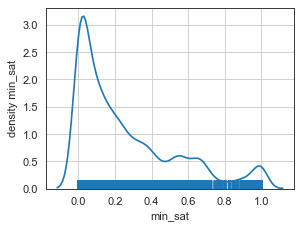

In [7]:
# x: input
df_x = df[['primary_A', 'max_bw_ix_A', 'load_ix_A',\
           'primary_B', 'max_bw_ix_B', 'load_ix_B',\
           'primary_C', 'max_bw_ix_C', 'load_ix_C',\
           'primary_D', 'max_bw_ix_D', 'load_ix_D']]

# y: metric_to_optimize should be 'satis' or 'delay' for satisfaction and delay, respectively
metric_to_optimize = 'satis'
#metric_to_optimize = 'delay'
if metric_to_optimize == 'delay':
    df_y = df_max_delay
    df_y.columns = ['max_delay']
    df_y_A = df_delay['d_A']
    df_y_B = df_delay['d_B']
    df_y_C = df_delay['d_C']
    df_y_D = df_delay['d_D']
elif metric_to_optimize == 'satis':
    df_y = df_min_sat
    df_y.columns = ['min_sat']
    df_y_A = df_sat['sat_A']
    df_y_B = df_sat['sat_B']
    df_y_C = df_sat['sat_C']
    df_y_D = df_sat['sat_D']
    df_y_mean = df_mean_sat
    df_y_mean.columns = ['df_mean_sat'] 

    
# Filter by load? LOAD_MBPS sets the load in Mbps to be set in ALL the BSS's.
filter_by_load = True
LOAD_MBPS = 50;
if filter_by_load:
    # We assume first that the load is fixed and the same for every BSS
    ixs_load = df.index[(df['load_A'] == LOAD_MBPS* FACTOR_PKTPERSEC_TO_MBPS)\
                        & (df['load_B'] == LOAD_MBPS*FACTOR_PKTPERSEC_TO_MBPS)\
                        & (df['load_C'] == LOAD_MBPS*FACTOR_PKTPERSEC_TO_MBPS)\
                        & (df['load_D'] == LOAD_MBPS*FACTOR_PKTPERSEC_TO_MBPS)].tolist()
    if 'load_ix_A' in df_x:
        del df_x['load_ix_A']
    if 'load_ix_B' in df_x:
        del df_x['load_ix_B']
    if 'load_ix_C' in df_x:
        del df_x['load_ix_C']
    if 'load_ix_D' in df_x:
        del df_x['load_ix_D']
        
    df_x_filtered = df_x.loc[ixs_load]
    df_y_filtered = df_y.loc[ixs_load]
    
    # We first assume constant and same load at every AP
    # Loads: [20 50 150] Mbps

    df_y_A_filtered = df_y_A.loc[ixs_load]
    df_y_B_filtered = df_y_B.loc[ixs_load]
    df_y_C_filtered = df_y_C.loc[ixs_load]
    df_y_D_filtered = df_y_D.loc[ixs_load]
    
    df_y_mean_filtered = df_y_mean.loc[ixs_load]

else:
    df_x_filtered = df_x
    df_y_filtered = df_y

df_y_filtered.columns = [df_y.columns[0]]
num_samples_filtered = len(df_y_filtered.index)

df_y_mean_filtered.columns = [df_y_mean.columns[0]]

print('Overview of the WHOLE dataset (metric_to_optimize = "%s"):' % metric_to_optimize)
print('- BSS A: min = %.2f - mean = %.2f - max = %.2f' % (df_y_A.min(),df_y_A.mean(),df_y_A.max()))
print('- BSS B: min = %.2f - mean = %.2f - max = %.2f' % (df_y_B.min(),df_y_B.mean(),df_y_B.max()))
print('- BSS C: min = %.2f - mean = %.2f - max = %.2f' % (df_y_C.min(),df_y_C.mean(),df_y_C.max()))
print('- BSS D: min = %.2f - mean = %.2f - max = %.2f' % (df_y_D.min(),df_y_D.mean(),df_y_D.max()))

# Plot distribution of the selected performance metric to be optimized
%matplotlib inline
plot_data_pdf(df_y_filtered, df_y_filtered.columns[0], 'density ' + df_y_filtered.columns[0])


#### Dummy variables (binary categorical representation)
Generate dummy input, i.e., translate $x$ dimensions to categorical.

Note: this is a refinment step. Depending on the selected ML framework, dummy variables may not be necessary. In particular, we would me moving $x$ to have from 8 (1 $p$ value and 1 $b$ value per each of the 4 BSS's) to 28 (4 $p$ values and 3 $b$ values) dimensions.

E.g., since primary $p\in\{0,1,2,3\}$:
- $p=0 \rightarrow \{p_0 = 1, p_1 = 0, p_2 = 0, p_3 = 0\}$
- $p=1 \rightarrow \{p_0 = 0, p_1 = 1, p_2 = 0, p_3 = 0\}$
- $p=2 \rightarrow \{p_0 = 0, p_1 = 0, p_2 = 1, p_3 = 0\}$
- $p=3 \rightarrow \{p_0 = 0, p_1 = 0, p_2 = 0, p_3 = 1\}$

where $p_i = 1$ if channel $p=i$, and $p_i = 0$ otherwise.

Variables:
- `df_x_filtered_dummy`: set of input samples $x$ filtered by the load $\ell=$LOAD_MBPS

In [8]:
# Generate proper input x by creating dummy variables for each feature (p,b)
if filter_by_load:
    df_x_filtered_dummy = pd.get_dummies(df_x_filtered,\
                                   prefix=['primary_A', 'max_bw_ix_A',\
                                           'primary_B', 'max_bw_ix_B',\
                                           'primary_C', 'max_bw_ix_C',\
                                           'primary_D', 'max_bw_ix_D'],\
                                   columns=['primary_A', 'max_bw_ix_A',\
                                            'primary_B', 'max_bw_ix_B',\
                                            'primary_C', 'max_bw_ix_C',\
                                            'primary_D', 'max_bw_ix_D'])
else:
    df_x_filtered_dummy = pd.get_dummies(df_x_filtered,\
                                   prefix=['primary_A', 'max_bw_ix_A',\
                                           'primary_B', 'max_bw_ix_B',\
                                           'primary_C', 'max_bw_ix_C',\
                                           'primary_D', 'max_bw_ix_D'],\
                                   columns=['primary_A', 'max_bw_ix_A',\
                                            'primary_B', 'max_bw_ix_B',\
                                            'primary_C', 'max_bw_ix_C',\
                                            'primary_D', 'max_bw_ix_D'])
    
X_FILTERED_DIMENSION = len(df_x_filtered.columns)
X_FILTERED_DUMMY_DIMENSION = len(df_x_filtered_dummy.columns)

print('input x filtered (dimension %d):' % X_FILTERED_DIMENSION)
print(df_x_filtered.head())

print('input x filtered dummy (dimension %d):' % X_FILTERED_DUMMY_DIMENSION)
print(df_x_filtered_dummy.head())

input x filtered (dimension 8):
       primary_A  max_bw_ix_A  primary_B  max_bw_ix_B  primary_C  max_bw_ix_C  \
47989          0            1          0            1          0            1   
47992          0            1          0            1          0            1   
47995          0            1          0            1          0            1   
47998          0            1          0            1          0            1   
48001          0            1          0            1          0            1   

       primary_D  max_bw_ix_D  
47989          0            1  
47992          0            2  
47995          0            3  
47998          1            1  
48001          1            2  
input x filtered dummy (dimension 28):
       primary_A_0  primary_A_1  primary_A_2  primary_A_3  max_bw_ix_A_1  \
47989            1            0            0            0              1   
47992            1            0            0            0              1   
47995            1    

#### Final filtered dataset
Dataset containing filtered input (dummy or raw) and output

In [9]:
df_filtered = pd.concat([df_x_filtered, df_y_filtered], axis=1, sort=False)
df_filtered_dummy = pd.concat([df_x_filtered_dummy, df_y_filtered], axis=1, sort=False)

### Overview of filtered dataset
Check out the filtered dataset

In [10]:
OPTIMAL_MIN_SAT_MARGIN = 0.00  # if achieved sat >= optimal throughput - OPTIMAL_MIN_SAT_MARGIN, OKAY
OPTIMAL_MAX_DELAY_MARGIN = 2

# Overview of the filtered dataset
print('Overview of the FILTERED dataset (load %d Mbps, metric_to_optimize = "%s"):' % (LOAD_MBPS, metric_to_optimize))

min_y = df_y_filtered.min()
mean_y = df_y_filtered.mean()
max_y = df_y_filtered.max()

objective_y = df_y_filtered.max()
optimal_confs_ix = df_y_filtered.loc[df_y >= (objective_y-OPTIMAL_MIN_SAT_MARGIN)]
objective_y_mean = df_y_mean_filtered.max()

if metric_to_optimize == 'delay':
    # delay ---> minimize
    objective_y = df_y_filtered.min()
    objective_action_ix = np.argmin(df_y_filtered)
    optimal_confs_ix = df_y_filtered.loc[df_y_filtered <= (objective_y + OPTIMAL_MAX_DELAY_MARGIN)]
elif metric_to_optimize == 'satis':
    # satisfaction ---> maximize
    objective_y = df_y_filtered.max()
    objective_action_ix = np.argmax(df_y_filtered)
    optimal_confs_ix = df_y_filtered.loc[df_y >= (objective_y-OPTIMAL_MIN_SAT_MARGIN)]

num_optimal_confs = len(optimal_confs_ix)

print('- min = %.2f\n- mean = %.2f\n- max = %.2f' % (min_y,mean_y,max_y))
print('- objective_y = %.2f' % objective_y)
print('- objective_action_ix = %d' % objective_action_ix)
print('   * num_optimal_confs = %d/%d (%.2f %%)' % 
      (num_optimal_confs, num_samples_filtered, num_optimal_confs/num_samples_filtered * 100))


# Optimal global configuration ind detail
obj_a = df.iloc[objective_action_ix]
print('Optimal global configuration:')
print(obj_a)

print('Optimal global configuration: p_A = %d, b_A = %d, p_B = %d, b_B = %d, p_C = %d, b_C = %d, p_D = %d, b_D = %d' % (obj_a['primary_A'], obj_a['max_bw_ix_A'], obj_a['primary_B'], obj_a['max_bw_ix_B'], obj_a['primary_C'], obj_a['max_bw_ix_C'], obj_a['primary_D'], obj_a['max_bw_ix_D']))


Overview of the FILTERED dataset (load 50 Mbps, metric_to_optimize = "satis"):
- min = 0.00
- mean = 0.26
- max = 1.00
- objective_y = 1.00
- objective_action_ix = 60328
   * num_optimal_confs = 416/20736 (2.01 %)
Optimal global configuration:
sim_code           KOMONDOR SIMULATION 'sim_status0060329' (seed...
bss_A_code                                                        A
action_ix_A                                                       1
status_ix_A                                                       2
primary_A                                                         0
max_bw_ix_A                                                       1
load_ix_A                                                         2
load_A                                                       4166.5
thr_A                                                         50.33
d_A                                                            3.37
rts_lost_A                                                        0
rts_sent

C:\Users\UPF\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return bound(*args, **kwds)


# ML approach: RL agents at the edge
Each AP runs a MAB at its own trying to greedely boost its performance.

In [11]:
print('- BSS A: min = %.2f - mean = %.2f - max = %.2f' % (df_y_A_filtered.min(),df_y_A_filtered.mean(),df_y_A_filtered.max()))
print('- BSS B: min = %.2f - mean = %.2f - max = %.2f' % (df_y_B_filtered.min(),df_y_B_filtered.mean(),df_y_B_filtered.max()))
print('- BSS C: min = %.2f - mean = %.2f - max = %.2f' % (df_y_C_filtered.min(),df_y_C_filtered.mean(),df_y_C_filtered.max()))
print('- BSS D: min = %.2f - mean = %.2f - max = %.2f' % (df_y_D_filtered.min(),df_y_D_filtered.mean(),df_y_D_filtered.max()))

df_dataset_dummy = pd.concat([df_x_filtered,df_y_A_filtered,df_y_B_filtered,df_y_C_filtered,df_y_D_filtered],\
                             axis=1, sort=False)

df_dataset_dummy.reset_index(drop=True, inplace=True)

# Action space per BSS
# - there are 4 possible actions per agent (x2 primary value, x2 max. bw)
df_x_A = df[['primary_A', 'max_bw_ix_A']]
df_x_A_unique = df_x_A.drop_duplicates()
df_x_A_dummy = pd.get_dummies(df_x_A_unique,\
                                   prefix=['primary_A', 'max_bw_ix_A'],\
                                   columns=['primary_A', 'max_bw_ix_A'])

df_x_B = df[['primary_B', 'max_bw_ix_B']]
df_x_B_unique = df_x_B.drop_duplicates()
df_x_B_dummy = pd.get_dummies(df_x_B_unique,\
                                   prefix=['primary_B', 'max_bw_ix_B'],\
                                   columns=['primary_B', 'max_bw_ix_B'])

df_x_C = df[['primary_C', 'max_bw_ix_C']]
df_x_C_unique = df_x_C.drop_duplicates()
df_x_C_dummy = pd.get_dummies(df_x_C_unique,\
                                   prefix=['primary_C', 'max_bw_ix_C'],\
                                   columns=['primary_C', 'max_bw_ix_C'])

df_x_D = df[['primary_D', 'max_bw_ix_D']]
df_x_D_unique = df_x_D.drop_duplicates()
df_x_D_dummy = pd.get_dummies(df_x_D_unique,\
                                   prefix=['primary_D', 'max_bw_ix_D'],\
                                   columns=['primary_D', 'max_bw_ix_D'])

# - global action space (considering config of every BSS)
df_x_aux = pd.concat([df_x_A, df_x_B, df_x_C, df_x_D], axis=1, sort=False)
df_x_unique = df_x_aux.drop_duplicates()
df_x_dummy = pd.get_dummies(df_x_unique,\
                                   prefix=['primary_A', 'max_bw_ix_A',\
                                           'primary_B', 'max_bw_ix_B',\
                                           'primary_C', 'max_bw_ix_C',\
                                           'primary_D', 'max_bw_ix_D'],\
                                   columns=['primary_A', 'max_bw_ix_A',\
                                           'primary_B', 'max_bw_ix_B',\
                                           'primary_C', 'max_bw_ix_C',\
                                           'primary_D', 'max_bw_ix_D'])

df_x_dummy.reset_index(drop=True, inplace=True)

#df_dataset_dummy

- BSS A: min = 0.00 - mean = 0.53 - max = 1.00
- BSS B: min = 0.00 - mean = 0.76 - max = 1.00
- BSS C: min = 0.00 - mean = 0.62 - max = 1.00
- BSS D: min = 0.00 - mean = 0.79 - max = 1.00


# MABs at the edge

### Function for running the MAB

In [12]:
def run_mab(NUM_ITERATIONS,mab_A,mab_B,mab_C,mab_D,reward_type):

    # MAB process:
    # - 1. every BSS picks action simultaneously
    # - 2. check reward of each BSS by looking the global dataset
    # - 3. update MAB with the last reward
    # - 4. go to step 1
    
    print("iteration: ", end='')
    
    for it in range(NUM_ITERATIONS):
        
        
        print("%d, " % it, end='')

        # 1. every BSS picks action
        action_ix_A = mab_A.select_action()
        action_ix_B = mab_B.select_action()
        action_ix_C = mab_C.select_action()
        action_ix_D = mab_D.select_action()

        # 2. check reward
        # - convert action index to dummy representation of the status features (primary and max_bw_ix)
        action_A_dummy = df_x_A_dummy.iloc[action_ix_A]
        action_B_dummy = df_x_B_dummy.iloc[action_ix_B]
        action_C_dummy = df_x_C_dummy.iloc[action_ix_C]
        action_D_dummy = df_x_D_dummy.iloc[action_ix_D]

        action_global = pd.concat([action_A_dummy, action_B_dummy, action_C_dummy, action_D_dummy], axis=0, sort=False)
        for i, row in df_x_dummy.iterrows():
            if action_global.equals(row):
                action_ix_global = i
                break
        status_reward = df_dataset_dummy.iloc[action_ix_global]
        
        if reward_type == 'delay':
            # delay ---> minimize
            MIN_EXPECTED_DELAY = 0.1
            r_A = MIN_EXPECTED_DELAY / status_reward['d_A']
            r_B = MIN_EXPECTED_DELAY / status_reward['d_B']
            r_C = MIN_EXPECTED_DELAY / status_reward['d_C']
            r_D = MIN_EXPECTED_DELAY / status_reward['d_D']
        
        elif reward_type == 'satis':
            # satisfaction ---> maximize
            r_A = status_reward['sat_A']
            r_B = status_reward['sat_B']
            r_C = status_reward['sat_C']
            r_D = status_reward['sat_D']

        # 3. update MAB with the last reward
        mab_A.update_reward(action_ix_A, r_A)
        mab_B.update_reward(action_ix_B, r_B)
        mab_C.update_reward(action_ix_C, r_C)
        mab_D.update_reward(action_ix_D, r_D)
    

In [13]:
RAND_SEED = 1992
random.seed(a=RAND_SEED, version=2)
NUM_ARMS = 12 # 4 primaries (0,1,2,3) and 3 max bandwidths ixs (1,2,3) corresponding to (20,40,80) MHz
NUM_ITERATIONS = 200

# create MAB model

# mab_A = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="A-eps")
# mab_B = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="B-eps")
# mab_C = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="C-eps")
# mab_D = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="D-eps")

# mab_A = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="A-tsbeta")
# mab_B = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="B-tsbeta")
# mab_C = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="C-tsbeta")
# mab_D = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="D-tsbeta")

# mab_A = mab.UCB1_mab(num_arms = NUM_ARMS, name="A-ucb")
# mab_B = mab.UCB1_mab(num_arms = NUM_ARMS, name="B-ucb")
# mab_C = mab.UCB1_mab(num_arms = NUM_ARMS, name="C-ucb")
# mab_D = mab.UCB1_mab(num_arms = NUM_ARMS, name="D-ucb")

# run_mab(NUM_ITERATIONS,mab_A,mab_B,mab_C,mab_D,'satis')

# # summary
# mab_A.print_summary()
# mab_B.print_summary()
# mab_C.print_summary()
# mab_D.print_summary()

mab_A_explfirst = mab.Explfirst_mab(num_arms = NUM_ARMS, name="A-explfirst")
mab_B_explfirst = mab.Explfirst_mab(num_arms = NUM_ARMS, name="B-explfirst")
mab_C_explfirst = mab.Explfirst_mab(num_arms = NUM_ARMS, name="C-explfirst")
mab_D_explfirst = mab.Explfirst_mab(num_arms = NUM_ARMS, name="D-explfirst")

mab_A_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="A-eps")
mab_B_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="B-eps")
mab_C_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="C-eps")
mab_D_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="D-eps")

alpha = 0.1
gamma = 0.95
epsilon_original = 1
mab_A_slql = mab.Stateless_qlearning(epsilon_original, alpha, gamma, num_arms = NUM_ARMS, name="A-slql")
mab_B_slql = mab.Stateless_qlearning(epsilon_original, alpha, gamma, num_arms = NUM_ARMS, name="B-slql")
mab_C_slql = mab.Stateless_qlearning(epsilon_original, alpha, gamma, num_arms = NUM_ARMS, name="C-slql")
mab_D_slql = mab.Stateless_qlearning(epsilon_original, alpha, gamma, num_arms = NUM_ARMS, name="D-slql")

mab_A_tsbeta = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="A-tsbeta")
mab_B_tsbeta = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="B-tsbeta")
mab_C_tsbeta = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="C-tsbeta")
mab_D_tsbeta = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="D-tsbeta")

mab_A_tsnormal = mab.Thompson_sampling_normal(num_arms = NUM_ARMS, distribution="normal", name="A-tsnormal")
mab_B_tsnormal = mab.Thompson_sampling_normal(num_arms = NUM_ARMS, distribution="normal", name="B-tsnormal")
mab_C_tsnormal = mab.Thompson_sampling_normal(num_arms = NUM_ARMS, distribution="normal", name="C-tsnormal")
mab_D_tsnormal = mab.Thompson_sampling_normal(num_arms = NUM_ARMS, distribution="normal", name="D-tsnormal")

mab_A_ucb = mab.UCB1_mab(num_arms = NUM_ARMS, name="A-ucb")
mab_B_ucb = mab.UCB1_mab(num_arms = NUM_ARMS, name="B-ucb")
mab_C_ucb = mab.UCB1_mab(num_arms = NUM_ARMS, name="C-ucb")
mab_D_ucb = mab.UCB1_mab(num_arms = NUM_ARMS, name="D-ucb")

mab_A_exp3 = mab.Exp3_mab(gamma = 0.2, num_arms = NUM_ARMS, name="A-exp3")
mab_B_exp3 = mab.Exp3_mab(gamma = 0.2, num_arms = NUM_ARMS, name="B-exp3")
mab_C_exp3 = mab.Exp3_mab(gamma = 0.2, num_arms = NUM_ARMS, name="C-exp3")
mab_D_exp3 = mab.Exp3_mab(gamma = 0.2, num_arms = NUM_ARMS, name="D-exp3")


# print('\nRuning explfirst:')
# run_mab(NUM_ITERATIONS,mab_A_explfirst,mab_B_explfirst,mab_C_explfirst,mab_D_explfirst,metric_to_optimize)
# print('\nRuning eps-greedy:')
# run_mab(NUM_ITERATIONS,mab_A_eps,mab_B_eps,mab_C_eps,mab_D_eps,metric_to_optimize)
# print('\nRuning TS-beta:')
# run_mab(NUM_ITERATIONS,mab_A_tsbeta,mab_B_tsbeta,mab_C_tsbeta,mab_D_tsbeta,metric_to_optimize)
# print('\nRuning TS-normal:')
# run_mab(NUM_ITERATIONS,mab_A_tsnormal,mab_B_tsnormal,mab_C_tsnormal,mab_D_tsnormal,metric_to_optimize)
# print('\nRuning UCB1:')
# run_mab(NUM_ITERATIONS,mab_A_ucb,mab_B_ucb,mab_C_ucb,mab_D_ucb,metric_to_optimize)
# print('\nRuning Exp3:')
# run_mab(NUM_ITERATIONS,mab_A_exp3,mab_B_exp3,mab_C_exp3,mab_D_exp3,metric_to_optimize)

### Plot learning results

In [14]:
def plot_histogram_mab(mab_A,mab_B,mab_C,mab_D,YLIM_REWARD):
    # histogram action reward
    x_pos = np.array(range(1,NUM_ARMS+1))
    YLIM_PROB = [0, 1]
    fig, ax = plt.subplots(2, 4,figsize=(10,5))
    ax[0,0].bar(x_pos, mab_A.mean_reward, align='center', alpha=0.5)
    ax[0,0].set_xticks(x_pos)
    ax[0,0].set_ylabel('mean reward')
    ax[0,0].set_title(mab_A.name)
    ax[0,0].set_ylim(YLIM_REWARD)
    ax[0,0].grid()

    prob_hist_A = mab_A.count_action_selected / np.sum(mab_A.count_action_selected)
    ax[1,0].bar(x_pos, prob_hist_A, align='center', alpha=0.5)
    ax[1,0].set_xticks(x_pos)
    ax[1,0].set_xlabel('action ix')
    ax[1,0].set_ylabel('prob. pick')
    ax[1,0].set_ylim(YLIM_PROB)
    ax[1,0].grid()

    ax[0,1].bar(x_pos, mab_B.mean_reward, align='center', alpha=0.5)
    ax[0,1].set_xticks(x_pos)
    ax[0,1].set_title(mab_B.name)
    ax[0,1].set_ylim(YLIM_REWARD)
    ax[0,1].grid()

    ax[1,1].bar(x_pos, mab_B.count_action_selected / np.sum(mab_B.count_action_selected)\
                , align='center', alpha=0.5)
    ax[1,1].set_xticks(x_pos)
    ax[1,1].set_xlabel('action ix')
    ax[1,1].set_ylim(YLIM_PROB)
    ax[1,1].grid()

    ax[0,2].bar(x_pos, mab_C.mean_reward, align='center', alpha=0.5)
    ax[0,2].set_xticks(x_pos)
    ax[0,2].set_title(mab_C.name)
    ax[0,2].set_ylim(YLIM_REWARD)
    ax[0,2].grid()

    ax[1,2].bar(x_pos, mab_C.count_action_selected / np.sum(mab_C.count_action_selected)\
                , align='center', alpha=0.5)
    ax[1,2].set_xticks(x_pos)
    ax[1,2].set_xlabel('action ix')
    ax[1,2].set_ylim(YLIM_PROB)
    ax[1,2].grid()

    ax[0,3].bar(x_pos, mab_D.mean_reward, align='center', alpha=0.5)
    ax[0,3].set_xticks(x_pos)
    ax[0,3].set_title(mab_D.name)
    ax[0,3].set_ylim(YLIM_REWARD)
    ax[0,3].grid()

    ax[1,3].bar(x_pos, mab_D.count_action_selected / np.sum(mab_D.count_action_selected)\
                , align='center', alpha=0.5)
    ax[0,3].set_xticks(x_pos)
    ax[1,3].set_xlabel('action ix')
    ax[1,3].set_ylim(YLIM_PROB)
    ax[1,3].grid()

    plt.show()
    
    
    return prob_hist_A

In [15]:
def plot_runchart_mab(NUM_ITERATIONS,mab_A,mab_B,mab_C,mab_D,opt_A,opt_B,opt_C,opt_D,opt_all,opt_all_mean,YLIM_REWARD,name=""):
    
    # Runchart
    iteration_array = np.array(range(1,NUM_ITERATIONS+1))
    reward_history_A = mab_A.reward_history
    mean_cum_reward_history_A = np.divide(np.cumsum(mab_A.reward_history), iteration_array)
    reward_history_B = mab_B.reward_history
    mean_cum_reward_history_B = np.divide(np.cumsum(mab_B.reward_history), iteration_array)
    reward_history_C = mab_C.reward_history
    mean_cum_reward_history_C = np.divide(np.cumsum(mab_C.reward_history), iteration_array)
    reward_history_D = mab_D.reward_history
    mean_cum_reward_history_D = np.divide(np.cumsum(mab_D.reward_history), iteration_array)

    reward_history_min_wlan = np.minimum.reduce(\
                                          [reward_history_A, reward_history_B,reward_history_C,reward_history_D])
    mean_cum_reward_history_wlan = np.divide(np.cumsum(reward_history_min_wlan), iteration_array)
    
    reward_history_mean_wlan = np.mean([reward_history_A, reward_history_B,reward_history_C,reward_history_D], axis=0)
    mean_cum_meanreward_history_wlan = np.divide(np.cumsum(reward_history_mean_wlan), iteration_array)
    
    fig, ax = plt.subplots(1, 6,figsize=(20,3))
    ax[0].plot(iteration_array, reward_history_A, 'r', label="reward") # plotting t, a separately 
    ax[0].plot(iteration_array, mean_cum_reward_history_A, 'b', label="mean_cum_reward") # plotting t, b separately 
    ax[0].plot(iteration_array, opt_A, 'y--', label="optimal")
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('reward')
    ax[0].grid()
    ax[0].set_title(mab_A.name)
    ax[0].set_ylim(YLIM_REWARD)
    ax[0].legend()

    ax[1].plot(iteration_array, reward_history_B, 'r', label="reward") # plotting t, a separately 
    ax[1].plot(iteration_array, mean_cum_reward_history_B, 'b', label="mean_cum_reward") # plotting t, b separately 
    ax[1].plot(iteration_array, opt_B, 'y--', label="optimal")
    ax[1].set_xlabel('iteration')
    ax[1].set_ylabel('reward')
    ax[1].grid()
    ax[1].set_title(mab_B.name)
    ax[1].set_ylim(YLIM_REWARD)
    ax[1].legend()

    ax[2].plot(iteration_array, reward_history_C, 'r', label="reward") # plotting t, a separately 
    ax[2].plot(iteration_array, mean_cum_reward_history_C, 'b', label="mean_cum_reward") # plotting t, b separately 
    ax[2].plot(iteration_array, opt_C, 'y--', label="optimal")
    ax[2].set_xlabel('iteration')
    ax[2].set_ylabel('reward')
    ax[2].grid()
    ax[2].set_title(mab_C.name)
    ax[2].set_ylim(YLIM_REWARD)
    ax[2].legend()

    ax[3].plot(iteration_array, reward_history_D, 'r', label="reward")
    ax[3].plot(iteration_array, mean_cum_reward_history_D, 'b', label="mean_cum_reward")
    ax[3].plot(iteration_array, opt_D, 'y--', label="optimal")
    ax[3].set_xlabel('iteration')
    ax[3].set_ylabel('reward')
    ax[3].grid()
    ax[3].set_title(mab_D.name)
    ax[3].set_ylim(YLIM_REWARD)
    ax[3].legend()

    ax[4].plot(iteration_array, reward_history_min_wlan, 'r', label="reward")
    ax[4].plot(iteration_array, mean_cum_reward_history_wlan, 'b', label="mean_cum_reward")
    ax[4].plot(iteration_array, opt_all, 'y--', label="optimal")
    ax[4].set_xlabel('iteration')
    ax[4].set_ylabel('reward')
    ax[4].grid()
    ax[4].set_title('min WLAN')
    ax[4].set_ylim(YLIM_REWARD)
    ax[4].legend()
    
    ax[5].plot(iteration_array, reward_history_mean_wlan, 'r', label="reward")
    ax[5].plot(iteration_array, mean_cum_meanreward_history_wlan, 'b', label="mean_cum_reward")
    ax[5].plot(iteration_array, opt_all_mean, 'y--', label="optimal")
    ax[5].set_xlabel('iteration')
    ax[5].set_ylabel('reward')
    ax[5].grid()
    ax[5].set_title('mean WLAN')
    ax[5].set_ylim(YLIM_REWARD)
    ax[5].legend()
    plt.show()
    
    

    # create matrix for each MAB to be saved to txt
    summary_array = np.stack((mab_A.reward_history, mab_B.reward_history, mab_C.reward_history,\
                            mab_D.reward_history,reward_history_min_wlan,reward_history_mean_wlan,\
                              mean_cum_reward_history_A, mean_cum_reward_history_B,mean_cum_reward_history_C,\
                              mean_cum_reward_history_D,mean_cum_reward_history_wlan,mean_cum_meanreward_history_wlan,\
                              opt_A,opt_B,opt_C,opt_D,opt_all,opt_all_mean))
    
        
    return summary_array.transpose()


In [16]:
def plot_runchart_vsoptimal_mab(NUM_ITERATIONS,mab_A,mab_B,mab_C,mab_D,opt_A,opt_B,opt_C,opt_D,opt_all,YLIM_REWARD):
    
    # Runchart
    iteration_array = np.array(range(1,NUM_ITERATIONS+1))
    reward_history_A = mab_A.reward_history
    reward_history_B = mab_B.reward_history
    reward_history_C = mab_C.reward_history
    reward_history_D = mab_D.reward_history
    mean_cum_reward_history_D = np.divide(np.cumsum(mab_D.reward_history), iteration_array)

    reward_history_min_wlan = reward_history_min_wlan = np.minimum.reduce(\
                                          [reward_history_A, reward_history_B,reward_history_C,reward_history_D])

    
    fig, ax = plt.subplots(1, 5,figsize=(20,3))
    ax[0].plot(iteration_array, np.divide(reward_history_A, opt_A), 'g', label="reward") # plotting t, a separately 
    ax[0].set_xlabel('iteration')
    ax[0].set_ylabel('rho')
    ax[0].grid()
    ax[0].set_title(mab_A.name)
    ax[0].set_ylim(YLIM_REWARD)

    ax[1].plot(iteration_array, reward_history_B / opt_B, 'g', label="reward") # plotting t, a separately 
    ax[1].set_xlabel('iteration')
    ax[1].set_ylabel('rho')
    ax[1].grid()
    ax[1].set_title(mab_B.name)
    ax[1].set_ylim(YLIM_REWARD)

    ax[2].plot(iteration_array, reward_history_C / opt_C, 'g', label="reward") # plotting t, a separately 
    ax[2].set_xlabel('iteration')
    ax[2].set_ylabel('rho')
    ax[2].grid()
    ax[2].set_title(mab_C.name)
    ax[2].set_ylim(YLIM_REWARD)

    ax[3].plot(iteration_array, reward_history_D / opt_D, 'g', label="reward")
    ax[3].set_xlabel('iteration')
    ax[3].set_ylabel('rho')
    ax[3].grid()
    ax[3].set_title(mab_D.name)
    ax[3].set_ylim(YLIM_REWARD)

    ax[4].plot(iteration_array, reward_history_min_wlan / opt_all, 'g', label="reward")
    ax[4].set_xlabel('iteration')
    ax[4].set_ylabel('rho')
    ax[4].grid()
    ax[4].set_title('min WLAN')
    ax[4].set_ylim(YLIM_REWARD)
    plt.show()
    

In [ ]:
YLIM_REWARD = [0, 1.1]

opt_A = [df_y_A_filtered.max()] * NUM_ITERATIONS
opt_B = [df_y_B_filtered.max()] * NUM_ITERATIONS
opt_C = [df_y_C_filtered.max()] * NUM_ITERATIONS
opt_D = [df_y_D_filtered.max()] * NUM_ITERATIONS
opt_WLAN = [objective_y] * NUM_ITERATIONS
opt_WLAN_mean = [objective_y_mean] * NUM_ITERATIONS

NUM_SIMULATIONS = 100
NUM_ITERATIONS = 200

for sim_ix in range(NUM_SIMULATIONS):
    print('\n -------- sim_ix: ', sim_ix)
    RAND_SEED = 2002 + sim_ix
    random.seed(a=RAND_SEED, version=2)
    
    mab_A_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="A-eps")
    mab_B_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="B-eps")
    mab_C_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="C-eps")
    mab_D_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="D-eps")
    
    run_mab(NUM_ITERATIONS,mab_A_eps,mab_B_eps,mab_C_eps,mab_D_eps,metric_to_optimize)
    mab_A = mab_A_eps
    mab_B = mab_B_eps
    mab_C = mab_C_eps
    mab_D = mab_D_eps
    filename_root ='epsilon_' + str(RAND_SEED)

    prob_hist_A = plot_histogram_mab(mab_A,mab_B,mab_C,mab_D,YLIM_REWARD)
    np.savetxt(filename_root+'_prob_hist_A.csv', prob_hist_A, delimiter=',', fmt='%.4f')

    if metric_to_optimize == 'satis':
        summary_array = plot_runchart_mab(NUM_ITERATIONS,mab_A,mab_B,mab_C,mab_D,opt_A,opt_B,opt_C,opt_D,opt_WLAN,opt_WLAN_mean,YLIM_REWARD)
        np.savetxt(filename_root+'_summary.csv', summary_array, delimiter=',', fmt='%.4f')
    else:
        MIN_EXPECTED_DELAY = 0.1
        mean_cum_reward_history_wlan_explfirst = plot_runchart_mab(NUM_ITERATIONS,mab_A,mab_B,mab_C,mab_D,MIN_EXPECTED_DELAY / objective_y,YLIM_REWARD)

# Q -learning agents at the edge

In [18]:
def run_qlearning(NUM_ITERATIONS,q_A,q_B,q_C,q_D,reward_type,num_states):

    # MAB process:
    # - 1. every BSS picks action simultaneously
    # - 2. check reward of each BSS by looking the global dataset
    # - 3. update Qlearnings with the last reward
    # - 4. go to step 1
    
    print("iteration: ", end='')
    
    s_new_A, s_new_B, s_new_C, s_new_D = 0, 0, 0, 0
    
    for it in range(NUM_ITERATIONS):
        
        s_A = s_new_A
        s_B = s_new_B
        s_C = s_new_C
        s_D = s_new_D
        
        print("%d, " % it, end='')

        # 1. every BSS picks action
        action_ix_A = q_A.select_action(s_A)
        action_ix_B = q_B.select_action(s_B)
        action_ix_C = q_C.select_action(s_C)
        action_ix_D = q_D.select_action(s_D)

        # 2. check reward
        # - convert action index to dummy representation of the status features (primary and max_bw_ix)
        action_A_dummy = df_x_A_dummy.iloc[action_ix_A]
        action_B_dummy = df_x_B_dummy.iloc[action_ix_B]
        action_C_dummy = df_x_C_dummy.iloc[action_ix_C]
        action_D_dummy = df_x_D_dummy.iloc[action_ix_D]

        action_global = pd.concat([action_A_dummy, action_B_dummy, action_C_dummy, action_D_dummy], axis=0, sort=False)
        for i, row in df_x_dummy.iterrows():
            if action_global.equals(row):
                action_ix_global = i
                break
        status_reward = df_dataset_dummy.iloc[action_ix_global]
        
        if reward_type == 'delay':
            # delay ---> minimize
            MIN_EXPECTED_DELAY = 0.1
            r_A = MIN_EXPECTED_DELAY / status_reward['d_A']
            r_B = MIN_EXPECTED_DELAY / status_reward['d_B']
            r_C = MIN_EXPECTED_DELAY / status_reward['d_C']
            r_D = MIN_EXPECTED_DELAY / status_reward['d_D']
        
        elif reward_type == 'satis':
            # satisfaction ---> maximize
            r_A = status_reward['sat_A']
            r_B = status_reward['sat_B']
            r_C = status_reward['sat_C']
            r_D = status_reward['sat_D']
     
        
        # State detection
        TRESHOLD_SATISFIED = 0.999
        satis_A, satis_B, satis_C, satis_D = 0,0,0,0
        if r_A > TRESHOLD_SATISFIED:
            satis_A = 1
        if r_B > TRESHOLD_SATISFIED:
            satis_B = 1 
        if r_C > TRESHOLD_SATISFIED:
            satis_C = 1 
        if r_D > TRESHOLD_SATISFIED:
            satis_D = 1 
        
        if num_states == 2:
            # - Binary (only satis)
            s_new_A, s_new_B, s_new_C, s_new_D = satis_A, satis_B, satis_C, satis_D
        elif num_states == 24:
            # - Satis + action
            NUM_ARMS = 12
            s_new_A = (satis_A * NUM_ARMS) + action_ix_A
            s_new_B = (satis_B * NUM_ARMS) + action_ix_B
            s_new_C = (satis_C * NUM_ARMS) + action_ix_C
            s_new_D = (satis_D * NUM_ARMS) + action_ix_D
        else:
            sys.exit('Invalid number of contexts')
            
        # 3. update MAB with the last reward
        q_A.update_reward(s_A, s_new_A, action_ix_A, r_A)
        q_B.update_reward(s_B, s_new_B,action_ix_B, r_B)
        q_C.update_reward(s_C, s_new_C,action_ix_C, r_C)
        q_D.update_reward(s_D, s_new_D,action_ix_D, r_D)
            

In [ ]:
NUM_ITERATIONS = 200
YLIM_REWARD = [0, 1.1]
num_arms = NUM_ARMS
# alpha = 0.8
# gamma = 0.2

alpha = 0.9
gamma = 0.1

opt_A = [df_y_A_filtered.max()] * NUM_ITERATIONS
opt_B = [df_y_B_filtered.max()] * NUM_ITERATIONS
opt_C = [df_y_C_filtered.max()] * NUM_ITERATIONS
opt_D = [df_y_D_filtered.max()] * NUM_ITERATIONS
opt_WLAN = [objective_y] * NUM_ITERATIONS
opt_WLAN_mean = [objective_y_mean] * NUM_ITERATIONS

NUM_SIMULATIONS = 67


for sim_ix in range(NUM_SIMULATIONS):

    
    RAND_SEED = 2025 + sim_ix
    print('\n -------- sim_ix: ', sim_ix)
    random.seed(a=RAND_SEED, version=2)

    # 2-states
    print('\n * 2-states') 
    num_states = 2
    q_A = Qlearning(epsilon_original, alpha, gamma, num_arms, num_states, name="ql_A")
    q_B = Qlearning(epsilon_original, alpha, gamma, num_arms, num_states, name="ql_B")
    q_C = Qlearning(epsilon_original, alpha, gamma, num_arms, num_states, name="ql_C")
    q_D = Qlearning(epsilon_original, alpha, gamma, num_arms, num_states, name="ql_D")

    run_qlearning(NUM_ITERATIONS,q_A,q_B,q_C,q_D,metric_to_optimize,num_states)

    mab_A = q_A
    mab_B = q_B
    mab_C = q_C
    mab_D = q_D
    filename_root ='qlearning_02states_alpha' + str(alpha) + '_gamma'+ str(gamma) + '_' + str(RAND_SEED)

    prob_hist_A = plot_histogram_mab(mab_A,mab_B,mab_C,mab_D,YLIM_REWARD)
    np.savetxt(filename_root+'_prob_hist_A.csv', prob_hist_A, delimiter=',', fmt='%.4f')

    if metric_to_optimize == 'satis':
        summary_array = plot_runchart_mab(NUM_ITERATIONS,mab_A,mab_B,mab_C,mab_D,opt_A,opt_B,opt_C,opt_D,opt_WLAN,opt_WLAN_mean,YLIM_REWARD)
        np.savetxt(filename_root+'_summary.csv', summary_array, delimiter=',', fmt='%.4f')

    # 24-states
    print('\n * 24-states') 
    num_states = 24
    q_A_24state = Qlearning(epsilon_original, alpha, gamma, num_arms, num_states, name="ql_A")
    q_B_24state = Qlearning(epsilon_original, alpha, gamma, num_arms, num_states, name="ql_B")
    q_C_24state = Qlearning(epsilon_original, alpha, gamma, num_arms, num_states, name="ql_C")
    q_D_24state = Qlearning(epsilon_original, alpha, gamma, num_arms, num_states, name="ql_D")

    run_qlearning(NUM_ITERATIONS,q_A_24state,q_B_24state,q_C_24state,q_D_24state,metric_to_optimize,num_states)

    mab_A = q_A_24state
    mab_B = q_B_24state
    mab_C = q_C_24state
    mab_D = q_D_24state
    filename_root ='qlearning_24states_alpha' + str(alpha) + '_gamma'+ str(gamma)+ '_' + str(RAND_SEED)

    prob_hist_A = plot_histogram_mab(mab_A,mab_B,mab_C,mab_D,YLIM_REWARD)
    np.savetxt(filename_root+'_prob_hist_A.csv', prob_hist_A, delimiter=',', fmt='%.4f')

    if metric_to_optimize == 'satis':
        summary_array = plot_runchart_mab(NUM_ITERATIONS,mab_A,mab_B,mab_C,mab_D,opt_A,opt_B,opt_C,opt_D,opt_WLAN,opt_WLAN_mean,YLIM_REWARD)
        np.savetxt(filename_root+'_summary.csv', summary_array, delimiter=',', fmt='%.4f')


 -------- sim_ix:  0

 * 2-states
iteration: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 

# --- End of Q-learning

# Contextual MABs at the edge

In [ ]:
def run_contextual_mab(NUM_ITERATIONS,mab_A,mab_B,mab_C,mab_D,reward_type,num_contexts):

    # MAB process:
    # - 1. every BSS picks action simultaneously
    # - 2. check reward of each BSS by looking the global dataset
    # - 3. update Qlearnings with the last reward
    # - 4. go to step 1
    
    print("iteration: ", end='')
    
    c_A, c_B, c_C, c_D = 0, 0, 0, 0
    
    for it in range(NUM_ITERATIONS):

        print("%d, " % it, end='')

        # 1. every BSS picks action
        action_ix_A = mab_A.select_action(c_A)
        action_ix_B = mab_B.select_action(c_B)
        action_ix_C = mab_C.select_action(c_C)
        action_ix_D = mab_D.select_action(c_D)

        # 2. check reward
        # - convert action index to dummy representation of the status features (primary and max_bw_ix)
        action_A_dummy = df_x_A_dummy.iloc[action_ix_A]
        action_B_dummy = df_x_B_dummy.iloc[action_ix_B]
        action_C_dummy = df_x_C_dummy.iloc[action_ix_C]
        action_D_dummy = df_x_D_dummy.iloc[action_ix_D]

        action_global = pd.concat([action_A_dummy, action_B_dummy, action_C_dummy, action_D_dummy], axis=0, sort=False)
        for i, row in df_x_dummy.iterrows():
            if action_global.equals(row):
                action_ix_global = i
                break
        status_reward = df_dataset_dummy.iloc[action_ix_global]
        
        if reward_type == 'delay':
            # delay ---> minimize
            MIN_EXPECTED_DELAY = 0.1
            r_A = MIN_EXPECTED_DELAY / status_reward['d_A']
            r_B = MIN_EXPECTED_DELAY / status_reward['d_B']
            r_C = MIN_EXPECTED_DELAY / status_reward['d_C']
            r_D = MIN_EXPECTED_DELAY / status_reward['d_D']
        
        elif reward_type == 'satis':
            # satisfaction ---> maximize
            r_A = status_reward['sat_A']
            r_B = status_reward['sat_B']
            r_C = status_reward['sat_C']
            r_D = status_reward['sat_D']
            
        # 3. update MAB with the last reward
        mab_A.update_reward(c_A, action_ix_A, r_A)
        mab_B.update_reward(c_B,action_ix_B, r_B)
        mab_C.update_reward(c_C,action_ix_C, r_C)
        mab_D.update_reward(c_D,action_ix_D, r_D)
        
        # State detection
        TRESHOLD_SATISFIED = 0.999
        satis_A, satis_B, satis_C, satis_D = 0,0,0,0
        if r_A > TRESHOLD_SATISFIED:
            satis_A = 1
        if r_B > TRESHOLD_SATISFIED:
            satis_B = 1 
        if r_C > TRESHOLD_SATISFIED:
            satis_C = 1 
        if r_D > TRESHOLD_SATISFIED:
            satis_D = 1 
        
        if num_contexts == 2:
            # - Binary (only satis)
            c_A, c_B, c_C, c_D = satis_A, satis_B, satis_C, satis_D
        elif num_contexts == 24:
            # - Satis + action
            NUM_ARMS = 12
            c_A = (satis_A * NUM_ARMS) + action_ix_A
            c_B = (satis_B * NUM_ARMS) + action_ix_B
            c_C = (satis_C * NUM_ARMS) + action_ix_C
            c_D = (satis_D * NUM_ARMS) + action_ix_D
        else:
            sys.exit('Invalid number of contexts')
            

In [ ]:
YLIM_REWARD = [0, 1.1]

opt_A = [df_y_A_filtered.max()] * NUM_ITERATIONS
opt_B = [df_y_B_filtered.max()] * NUM_ITERATIONS
opt_C = [df_y_C_filtered.max()] * NUM_ITERATIONS
opt_D = [df_y_D_filtered.max()] * NUM_ITERATIONS
opt_WLAN = [objective_y] * NUM_ITERATIONS
opt_WLAN_mean = [objective_y_mean] * NUM_ITERATIONS


NUM_SIMULATIONS = 90
NUM_ITERATIONS = 200
epsilon_original = 1.0

for sim_ix in range(NUM_SIMULATIONS):
    print('\n -------- sim_ix: ', sim_ix)
    RAND_SEED = 2002 + sim_ix
    random.seed(a=RAND_SEED, version=2)

    # 2 contexts
    num_contexts = 2
    mab_A_contegreedy = Contextual_egreedy_mab(epsilon_original, num_arms = NUM_ARMS, name="A-contegreedy")
    mab_B_contegreedy = Contextual_egreedy_mab(epsilon_original, num_arms = NUM_ARMS, name="B-contegreedy")
    mab_C_contegreedy = Contextual_egreedy_mab(epsilon_original, num_arms = NUM_ARMS, name="C-contegreedy")
    mab_D_contegreedy = Contextual_egreedy_mab(epsilon_original, num_arms = NUM_ARMS, name="D-contegreedy")
    run_contextual_mab(NUM_ITERATIONS,mab_A_contegreedy,mab_B_contegreedy,mab_C_contegreedy,mab_D_contegreedy,metric_to_optimize,num_contexts)

    mab_A = mab_A_contegreedy
    mab_B = mab_B_contegreedy
    mab_C = mab_C_contegreedy
    mab_D = mab_D_contegreedy
    filename_root ='contextual_epsilon_02contexts_' + str(RAND_SEED)
    
    prob_hist_A = plot_histogram_mab(mab_A,mab_B,mab_C,mab_D,YLIM_REWARD)
    np.savetxt(filename_root+'_prob_hist_A.csv', prob_hist_A, delimiter=',', fmt='%.4f')

    if metric_to_optimize == 'satis':
        summary_array = plot_runchart_mab(NUM_ITERATIONS,mab_A,mab_B,mab_C,mab_D,opt_A,opt_B,opt_C,opt_D,opt_WLAN,opt_WLAN_mean,YLIM_REWARD)
        np.savetxt(filename_root+'_summary.csv', summary_array, delimiter=',', fmt='%.4f')
    
    # 24 contexts
    
    num_contexts = 24
    mab_A_contegreedy_24 = Contextual_egreedy_24_mab(epsilon_original, num_arms = NUM_ARMS, name="A-contegreedy_24")
    mab_B_contegreedy_24 = Contextual_egreedy_24_mab(epsilon_original, num_arms = NUM_ARMS, name="B-contegreedy_24")
    mab_C_contegreedy_24 = Contextual_egreedy_24_mab(epsilon_original, num_arms = NUM_ARMS, name="C-contegreedy_24")
    mab_D_contegreedy_24 = Contextual_egreedy_24_mab(epsilon_original, num_arms = NUM_ARMS, name="D-contegreedy_24")
    run_contextual_mab(NUM_ITERATIONS,mab_A_contegreedy_24,mab_B_contegreedy_24,mab_C_contegreedy_24,mab_D_contegreedy_24,metric_to_optimize,num_contexts)

    mab_A = mab_A_contegreedy_24
    mab_B = mab_B_contegreedy_24
    mab_C = mab_C_contegreedy_24
    mab_D = mab_D_contegreedy_24
    filename_root ='contextual_epsilon_24contexts_' + str(RAND_SEED)
    
    prob_hist_A = plot_histogram_mab(mab_A,mab_B,mab_C,mab_D,YLIM_REWARD)
    np.savetxt(filename_root+'_prob_hist_A.csv', prob_hist_A, delimiter=',', fmt='%.4f')

    if metric_to_optimize == 'satis':
        summary_array = plot_runchart_mab(NUM_ITERATIONS,mab_A,mab_B,mab_C,mab_D,opt_A,opt_B,opt_C,opt_D,opt_WLAN,opt_WLAN_mean,YLIM_REWARD)
        np.savetxt(filename_root+'_summary.csv', summary_array, delimiter=',', fmt='%.4f')


# --- End of Contextual MAB

In [ ]:
iteration_array = np.array(range(1,NUM_ITERATIONS+1))

plt.figure(figsize=(4,3), dpi= 80)
plt.plot(iteration_array, mean_cum_reward_history_wlan_explfirst, 'b', label="explfirst")
plt.plot(iteration_array, mean_cum_reward_history_wlan_eps, 'g', label="eps-greedy")
plt.plot(iteration_array, mean_cum_reward_history_wlan_tsbeta, 'c', label="tsbeta")
plt.plot(iteration_array, mean_cum_reward_history_wlan_ucb, 'm', label="ucb")
plt.plot(iteration_array, mean_cum_reward_history_wlan_exp3, 'r', label="exp3")
plt.plot(iteration_array, [objective_y] * NUM_ITERATIONS, 'y--', label="optimal")
plt.xlabel('iteration')
plt.ylabel('mean cum reward')    
plt.legend()
plt.title('min WLAN satisfaction')
plt.grid()
plt.ylim(YLIM_REWARD)


In [ ]:
# No. of iterations of the whole simulation
NUM_SIMULATION_ITERATIONS = 500
# No. of iterations between load triggers (100 or 200)
NUM_ITERATIONS_TO_LOAD_TRIGGER = 100
# No. of load triggers in the simulation
num_load_slots = math.ceil(NUM_SIMULATION_ITERATIONS / NUM_ITERATIONS_TO_LOAD_TRIGGER)

RAND_SEED = 1992
random.seed(a=RAND_SEED, version=2)

NUM_ARMS = 12

mab_A_explfirst = mab.Explfirst_mab(num_arms = NUM_ARMS, name="A-explfirst")
mab_B_explfirst = mab.Explfirst_mab(num_arms = NUM_ARMS, name="B-explfirst")
mab_C_explfirst = mab.Explfirst_mab(num_arms = NUM_ARMS, name="C-explfirst")
mab_D_explfirst = mab.Explfirst_mab(num_arms = NUM_ARMS, name="D-explfirst")

mab_A_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="A-eps")
mab_B_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="B-eps")
mab_C_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="C-eps")
mab_D_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="D-eps")

mab_A_tsbeta = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="A-tsbeta")
mab_B_tsbeta = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="B-tsbeta")
mab_C_tsbeta = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="C-tsbeta")
mab_D_tsbeta = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="D-tsbeta")

mab_A_ucb = mab.UCB1_mab(num_arms = NUM_ARMS, name="A-ucb")
mab_B_ucb = mab.UCB1_mab(num_arms = NUM_ARMS, name="B-ucb")
mab_C_ucb = mab.UCB1_mab(num_arms = NUM_ARMS, name="C-ucb")
mab_D_ucb = mab.UCB1_mab(num_arms = NUM_ARMS, name="D-ucb")

mab_A_exp3 = mab.Exp3_mab(gamma = 0.1, num_arms = NUM_ARMS, name="A-exp3")
mab_B_exp3 = mab.Exp3_mab(gamma = 0.1, num_arms = NUM_ARMS, name="B-exp3")
mab_C_exp3 = mab.Exp3_mab(gamma = 0.1, num_arms = NUM_ARMS, name="C-exp3")
mab_D_exp3 = mab.Exp3_mab(gamma = 0.1, num_arms = NUM_ARMS, name="D-exp3")


metric_to_optimize = 'satis'
#metric_to_optimize = 'mix'

# Optimal metric per iteration
opt_A = [-1] * NUM_SIMULATION_ITERATIONS
opt_B = [-1] * NUM_SIMULATION_ITERATIONS
opt_C = [-1] * NUM_SIMULATION_ITERATIONS
opt_D = [-1] * NUM_SIMULATION_ITERATIONS
opt_wlan = [-1] * NUM_SIMULATION_ITERATIONS
opt_wlan_mean = [-1] * NUM_SIMULATION_ITERATIONS

num_action_switch_A_evolution_explfirst = [-1] * NUM_SIMULATION_ITERATIONS
num_action_switch_A_evolution_eps = [-1] * NUM_SIMULATION_ITERATIONS
num_action_switch_B_evolution_explfirst = [-1] * NUM_SIMULATION_ITERATIONS
num_action_switch_B_evolution_eps = [-1] * NUM_SIMULATION_ITERATIONS
num_action_switch_C_evolution_explfirst = [-1] * NUM_SIMULATION_ITERATIONS
num_action_switch_C_evolution_eps = [-1] * NUM_SIMULATION_ITERATIONS
num_action_switch_D_evolution_explfirst = [-1] * NUM_SIMULATION_ITERATIONS
num_action_switch_D_evolution_eps = [-1] * NUM_SIMULATION_ITERATIONS

# [20, 20, 20, 150] ---> 0.82
# [20, 50, 150, 50] ---> 0.793
# [20, 150, 20, 20] ---> 0.793
# [50,50,50,50] ---> 1.0


# Load pattern 1
LOADS_HARDCODED = [[50,50,50,50],
    [50, 150, 150, 150],
    [20, 20, 20, 150],
    [150,20,50,50],
    [20,20,20,20]]

LOADS_HARDCODED = [[50,50,50,50],
    [50, 150, 150, 150],
    [20, 20, 20, 150],
    [150,150,150,150],
    [20,20,20,20]]

# Load pattern 2
# LOADS_HARDCODED = [[20,50,50,50],
#     [50, 20, 20, 150],
#     [20, 50, 50, 50]]

# Load pattern 3
# LOADS_HARDCODED = [[20,50,50,20],
#     [50, 150, 20, 150],
#     [50, 50, 50, 50]]

it_ix = 0

for load_trigger_ix in range(num_load_slots):

    print('- load_trigger_ix: %d / %d' % (load_trigger_ix, num_load_slots-1))

    # draw load for each BSS
    load_array = LOADS_HARDCODED[load_trigger_ix]
    print("  * New load triggered: load_array", load_array)

    # filter dataset by load
    out_filter = filter_dataset_by_load(df,load_array,metric_to_optimize)
    df_x_filtered = out_filter[0]
    df_y_filtered = out_filter[1]
    df_x_A_dummy = out_filter[2]
    df_x_B_dummy = out_filter[3]
    df_x_C_dummy = out_filter[4]
    df_x_D_dummy = out_filter[5]
    df_x_dummy = out_filter[6]
    df_dataset_dummy = out_filter[7]
    #print(df_x_filtered.head())  # Overview of data set
    #print(df_y_filtered.head())  # Overview of data set

    # optimal performance
    opt_A[it_ix:(it_ix + NUM_ITERATIONS_TO_LOAD_TRIGGER)] = [df_y_filtered['sat_A'].max()] * NUM_ITERATIONS_TO_LOAD_TRIGGER
    opt_B[it_ix:(it_ix + NUM_ITERATIONS_TO_LOAD_TRIGGER)] = [df_y_filtered['sat_B'].max()] * NUM_ITERATIONS_TO_LOAD_TRIGGER
    opt_C[it_ix:(it_ix + NUM_ITERATIONS_TO_LOAD_TRIGGER)] = [df_y_filtered['sat_C'].max()] * NUM_ITERATIONS_TO_LOAD_TRIGGER
    opt_D[it_ix:(it_ix + NUM_ITERATIONS_TO_LOAD_TRIGGER)] = [df_y_filtered['sat_D'].max()] * NUM_ITERATIONS_TO_LOAD_TRIGGER
    opt_wlan[it_ix:(it_ix + NUM_ITERATIONS_TO_LOAD_TRIGGER)] = [df_y_filtered['min_sat'].max()] * NUM_ITERATIONS_TO_LOAD_TRIGGER
    opt_wlan_mean[it_ix:(it_ix + NUM_ITERATIONS_TO_LOAD_TRIGGER)] = [df_y_mean_filtered.max()] * NUM_ITERATIONS_TO_LOAD_TRIGGER
    
#     print("  * Max performance:", df_y_filtered['min_sat'].max())
    print("  * it_ix_trigger (until %d): " % (NUM_ITERATIONS_TO_LOAD_TRIGGER-1), end='')
    # run MABs
    for it_ix_trigger in range(NUM_ITERATIONS_TO_LOAD_TRIGGER):
        print("%d, " % it_ix_trigger, end='')
        run_mab_step(mab_A_explfirst,mab_B_explfirst,mab_C_explfirst,mab_D_explfirst,metric_to_optimize)
        run_mab_step(mab_A_eps,mab_B_eps,mab_C_eps,mab_D_eps,metric_to_optimize)
        #run_mab_step(mab_A_tsbeta,mab_B_tsbeta,mab_C_tsbeta,mab_D_tsbeta,metric_to_optimize)
        #run_mab_step(mab_A_ucb,mab_B_ucb,mab_C_ucb,mab_D_ucb,metric_to_optimize)
        #run_mab_step(mab_A_exp3,mab_B_exp3,mab_C_exp3,mab_D_exp3,metric_to_optimize)
        
        num_action_switch_A_evolution_explfirst[it_ix] = mab_A_explfirst.num_action_switch
        num_action_switch_A_evolution_eps[it_ix] = mab_A_eps.num_action_switch
        
        num_action_switch_B_evolution_explfirst[it_ix] = mab_B_explfirst.num_action_switch
        num_action_switch_B_evolution_eps[it_ix] = mab_B_eps.num_action_switch
        
        num_action_switch_C_evolution_explfirst[it_ix] = mab_C_explfirst.num_action_switch
        num_action_switch_C_evolution_eps[it_ix] = mab_C_eps.num_action_switch
        
        num_action_switch_D_evolution_explfirst[it_ix] = mab_D_explfirst.num_action_switch
        num_action_switch_D_evolution_eps[it_ix] = mab_D_eps.num_action_switch
        
        it_ix = it_ix + 1
    print(" ")


In [ ]:
num_action_switch_summary = np.stack((num_action_switch_A_evolution_explfirst, num_action_switch_B_evolution_explfirst,\
                                     num_action_switch_C_evolution_explfirst,num_action_switch_D_evolution_explfirst,\
                                    num_action_switch_A_evolution_eps, num_action_switch_B_evolution_eps,\
                                     num_action_switch_C_evolution_eps,num_action_switch_D_evolution_eps))
    
        
num_action_switch_summary = num_action_switch_summary.transpose()

np.savetxt('num_action_switch_summary_varyingload.csv', num_action_switch_summary, delimiter=',', fmt='%.4f')

In [ ]:
YLIM_REWARD = [0, 1.1]

mab_A = mab_A_explfirst
mab_B = mab_B_explfirst
mab_C = mab_C_explfirst
mab_D = mab_D_explfirst

summary_array = plot_runchart_mab(NUM_SIMULATION_ITERATIONS,mab_A,mab_B,mab_C,mab_D,opt_A,opt_B,opt_C,opt_D,opt_wlan,opt_wlan_mean,YLIM_REWARD)

np.savetxt('explfirst_varyingload_summary.csv', summary_array, delimiter=',', fmt='%.4f')
np.savetxt('explfirst_varyingload_summary.csv', summary_array, delimiter=',', fmt='%.4f')

mab_A = mab_A_eps
mab_B = mab_B_eps
mab_C = mab_C_eps
mab_D = mab_D_eps

summary_array = plot_runchart_mab(NUM_SIMULATION_ITERATIONS,mab_A,mab_B,mab_C,mab_D,opt_A,opt_B,opt_C,opt_D,opt_wlan,opt_wlan_mean,YLIM_REWARD)

np.savetxt('eps_varyingload_summary.csv', summary_array, delimiter=',', fmt='%.4f')

mab_A = mab_A_tsbeta
mab_B = mab_B_tsbeta
mab_C = mab_C_tsbeta
mab_D = mab_D_tsbeta

mean_cum_reward_history_wlan_explfirst = plot_runchart_mab(NUM_SIMULATION_ITERATIONS,mab_A,mab_B,mab_C,mab_D,opt_A,opt_B,opt_C,opt_D,opt_wlan,opt_wlan,YLIM_REWARD)


mab_A = mab_A_ucb
mab_B = mab_B_ucb
mab_C = mab_C_ucb
mab_D = mab_D_ucb

mean_cum_reward_history_wlan_explfirst = plot_runchart_mab(NUM_SIMULATION_ITERATIONS,mab_A,mab_B,mab_C,mab_D,opt_A,opt_B,opt_C,opt_D,opt_wlan,opt_wlan,YLIM_REWARD)


mab_A = mab_A_exp3
mab_B = mab_B_exp3
mab_C = mab_C_exp3
mab_D = mab_D_exp3

mean_cum_reward_history_wlan_explfirst = plot_runchart_mab(NUM_SIMULATION_ITERATIONS,mab_A,mab_B,mab_C,mab_D,opt_A,opt_B,opt_C,opt_D,opt_wlan,opt_wlan,YLIM_REWARD)


In [ ]:
mab_A.reward_history

# *** Temporal changes in traffic load ***

Variables:
- `NUM_SIMULATION_ITERATIONS`: number of iterations of the whole simulation. FIXED.
- `NUM_ITERATIONS_TO_LOAD_TRIGGER`: number of iterations between load slots (or load triggers) where new loads are drawn from a probability distribution. FIXED.
- `num_load_slots`: number of load slots (or load triggers).

In [ ]:
# No. of iterations of the whole simulation
NUM_SIMULATION_ITERATIONS = 1000
# No. of iterations between load triggers (100 or 200)
NUM_ITERATIONS_TO_LOAD_TRIGGER = 200
# No. of load triggers in the simulation
num_load_slots = math.ceil(NUM_SIMULATION_ITERATIONS / NUM_ITERATIONS_TO_LOAD_TRIGGER)

LOADS_MBPS = [20, 50, 150]

RAND_SEED = 1992
random.seed(a=RAND_SEED, version=2)

NUM_SIMULATIONS = 10

opt_A_allsims = [[-1] * NUM_SIMULATION_ITERATIONS] * NUM_SIMULATIONS
opt_B_allsims = [[-1] * NUM_SIMULATION_ITERATIONS] * NUM_SIMULATIONS
opt_C_allsims = [[-1] * NUM_SIMULATION_ITERATIONS] * NUM_SIMULATIONS
opt_D_allsims = [[-1] * NUM_SIMULATION_ITERATIONS] * NUM_SIMULATIONS
opt_wlan_allsims = [[-1] * NUM_SIMULATION_ITERATIONS] * NUM_SIMULATIONS

NUM_ARMS = 12

mab_A_explfirst_allsims = [mab.Explfirst_mab(num_arms = NUM_ARMS, name="A-explfirst")] * NUM_SIMULATIONS
mab_B_explfirst_allsims = [mab.Explfirst_mab(num_arms = NUM_ARMS, name="B-explfirst")] * NUM_SIMULATIONS
mab_C_explfirst_allsims = [mab.Explfirst_mab(num_arms = NUM_ARMS, name="C-explfirst")] * NUM_SIMULATIONS
mab_D_explfirst_allsims = [mab.Explfirst_mab(num_arms = NUM_ARMS, name="D-explfirst")] * NUM_SIMULATIONS

mab_A_eps_allsims = [mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="A-eps")] * NUM_SIMULATIONS
mab_B_eps_allsims = [mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="B-eps")] * NUM_SIMULATIONS
mab_C_eps_allsims = [mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="C-eps")] * NUM_SIMULATIONS
mab_D_eps_allsims = [mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="D-eps")] * NUM_SIMULATIONS

mab_A_tsbeta_allsims = [mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="A-tsbeta")] * NUM_SIMULATIONS 
mab_B_tsbeta_allsims = [mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="B-tsbeta")] * NUM_SIMULATIONS 
mab_C_tsbeta_allsims = [mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="C-tsbeta")] * NUM_SIMULATIONS 
mab_D_tsbeta_allsims = [mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="D-tsbeta")] * NUM_SIMULATIONS 

mab_A_ucb_allsims = [mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="A-tsbeta")] * NUM_SIMULATIONS 
mab_B_ucb_allsims = [mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="B-tsbeta")] * NUM_SIMULATIONS 
mab_C_ucb_allsims = [mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="C-tsbeta")] * NUM_SIMULATIONS 
mab_D_ucb_allsims = [mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="D-tsbeta")] * NUM_SIMULATIONS 

mab_A_exp3_allsims = [mab.Exp3_mab(gamma = 0.1, num_arms = NUM_ARMS, name="A-exp3")] * NUM_SIMULATIONS 
mab_B_exp3_allsims = [mab.Exp3_mab(gamma = 0.1, num_arms = NUM_ARMS, name="B-exp3")] * NUM_SIMULATIONS 
mab_C_exp3_allsims = [mab.Exp3_mab(gamma = 0.1, num_arms = NUM_ARMS, name="C-exp3")] * NUM_SIMULATIONS 
mab_D_exp3_allsims = [mab.Exp3_mab(gamma = 0.1, num_arms = NUM_ARMS, name="D-exp3")] * NUM_SIMULATIONS 


for simulation_ix in range(NUM_SIMULATIONS):

    print('simulation_ix: %d / %d' % (simulation_ix, NUM_SIMULATIONS-1))
    
    NUM_ARMS = 12

    mab_A_explfirst = mab.Explfirst_mab(num_arms = NUM_ARMS, name="A-explfirst")
    mab_B_explfirst = mab.Explfirst_mab(num_arms = NUM_ARMS, name="B-explfirst")
    mab_C_explfirst = mab.Explfirst_mab(num_arms = NUM_ARMS, name="C-explfirst")
    mab_D_explfirst = mab.Explfirst_mab(num_arms = NUM_ARMS, name="D-explfirst")
    
    mab_A_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="A-eps")
    mab_B_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="B-eps")
    mab_C_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="C-eps")
    mab_D_eps = mab.Epsilongreedy_mab(epsilon_original = 1, num_arms = NUM_ARMS, name="D-eps")

    mab_A_tsbeta = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="A-tsbeta")
    mab_B_tsbeta = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="B-tsbeta")
    mab_C_tsbeta = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="C-tsbeta")
    mab_D_tsbeta = mab.Thompson_sampling_mab(num_arms = NUM_ARMS, distribution="beta", name="D-tsbeta")
    
    mab_A_ucb = mab.UCB1_mab(num_arms = NUM_ARMS, name="A-ucb")
    mab_B_ucb = mab.UCB1_mab(num_arms = NUM_ARMS, name="B-ucb")
    mab_C_ucb = mab.UCB1_mab(num_arms = NUM_ARMS, name="C-ucb")
    mab_D_ucb = mab.UCB1_mab(num_arms = NUM_ARMS, name="D-ucb")

    mab_A_exp3 = mab.Exp3_mab(gamma = 0.1, num_arms = NUM_ARMS, name="A-exp3")
    mab_B_exp3 = mab.Exp3_mab(gamma = 0.1, num_arms = NUM_ARMS, name="B-exp3")
    mab_C_exp3 = mab.Exp3_mab(gamma = 0.1, num_arms = NUM_ARMS, name="C-exp3")
    mab_D_exp3 = mab.Exp3_mab(gamma = 0.1, num_arms = NUM_ARMS, name="D-exp3")


    metric_to_optimize = 'satis'

    # Optimal metric per iteration
    opt_A = [-1] * NUM_SIMULATION_ITERATIONS
    opt_B = [-1] * NUM_SIMULATION_ITERATIONS
    opt_C = [-1] * NUM_SIMULATION_ITERATIONS
    opt_D = [-1] * NUM_SIMULATION_ITERATIONS
    opt_wlan = [-1] * NUM_SIMULATION_ITERATIONS

    it_ix = 0

    for load_trigger_ix in range(num_load_slots):

        print('- load_trigger_ix: %d / %d' % (load_trigger_ix, num_load_slots-1))

        # draw load for each BSS
        load_array = draw_loads(LOADS_MBPS)
        print("  * New load triggered: load_array", load_array)

        # filter dataset by load
        out_filter = filter_dataset_by_load(df,load_array,metric_to_optimize)
        df_x_filtered = out_filter[0]
        df_y_filtered = out_filter[1]
        df_x_A_dummy = out_filter[2]
        df_x_B_dummy = out_filter[3]
        df_x_C_dummy = out_filter[4]
        df_x_D_dummy = out_filter[5]
        df_x_dummy = out_filter[6]
        df_dataset_dummy = out_filter[7]
        #print(df_x_filtered.head())  # Overview of data set
        #print(df_y_filtered.head())  # Overview of data set

        # optimal performance
        opt_A[it_ix:(it_ix + NUM_ITERATIONS_TO_LOAD_TRIGGER)] = [df_y_filtered['sat_A'].max()] * NUM_ITERATIONS_TO_LOAD_TRIGGER
        opt_B[it_ix:(it_ix + NUM_ITERATIONS_TO_LOAD_TRIGGER)] = [df_y_filtered['sat_B'].max()] * NUM_ITERATIONS_TO_LOAD_TRIGGER
        opt_C[it_ix:(it_ix + NUM_ITERATIONS_TO_LOAD_TRIGGER)] = [df_y_filtered['sat_C'].max()] * NUM_ITERATIONS_TO_LOAD_TRIGGER
        opt_D[it_ix:(it_ix + NUM_ITERATIONS_TO_LOAD_TRIGGER)] = [df_y_filtered['sat_D'].max()] * NUM_ITERATIONS_TO_LOAD_TRIGGER
        opt_wlan[it_ix:(it_ix + NUM_ITERATIONS_TO_LOAD_TRIGGER)] = [df_y_filtered['min_sat'].max()] * NUM_ITERATIONS_TO_LOAD_TRIGGER
        print("  * Max performance:", df_y_filtered['min_sat'].max())
        print("  * it_ix_trigger (until %d): " % (NUM_ITERATIONS_TO_LOAD_TRIGGER-1), end='')
        # run MABs
        for it_ix_trigger in range(NUM_ITERATIONS_TO_LOAD_TRIGGER):
            print("%d, " % it_ix, end='')
            run_mab_step(mab_A_explfirst,mab_B_explfirst,mab_C_explfirst,mab_D_explfirst,metric_to_optimize)
            run_mab_step(mab_A_eps,mab_B_eps,mab_C_eps,mab_D_eps,metric_to_optimize)
            run_mab_step(mab_A_tsbeta,mab_B_tsbeta,mab_C_tsbeta,mab_D_tsbeta,metric_to_optimize)
            run_mab_step(mab_A_ucb,mab_B_ucb,mab_C_ucb,mab_D_ucb,metric_to_optimize)
            run_mab_step(mab_A_exp3,mab_B_exp3,mab_C_exp3,mab_D_exp3,metric_to_optimize)
            it_ix = it_ix + 1
        print(" ")
    
    # store optimal values
    opt_A_allsims[simulation_ix] = opt_A
    opt_B_allsims[simulation_ix] = opt_B
    opt_C_allsims[simulation_ix] = opt_C
    opt_D_allsims[simulation_ix] = opt_D
    opt_wlan_allsims[simulation_ix] = opt_wlan
    
    # store MABs
    mab_A_explfirst_allsims[simulation_ix] = mab_A_explfirst
    mab_B_explfirst_allsims[simulation_ix] = mab_B_explfirst
    mab_C_explfirst_allsims[simulation_ix] = mab_C_explfirst
    mab_D_explfirst_allsims[simulation_ix] = mab_D_explfirst
    
    mab_A_eps_allsims[simulation_ix] = mab_A_eps
    mab_B_eps_allsims[simulation_ix] = mab_B_eps
    mab_C_eps_allsims[simulation_ix] = mab_C_eps
    mab_D_eps_allsims[simulation_ix] = mab_D_eps
    
    mab_A_tsbeta_allsims[simulation_ix] = mab_A_tsbeta
    mab_B_tsbeta_allsims[simulation_ix] = mab_B_tsbeta
    mab_C_tsbeta_allsims[simulation_ix] = mab_C_tsbeta
    mab_D_tsbeta_allsims[simulation_ix] = mab_D_tsbeta
    
    mab_A_ucb_allsims[simulation_ix] = mab_A_ucb
    mab_B_ucb_allsims[simulation_ix] = mab_B_ucb
    mab_C_ucb_allsims[simulation_ix] = mab_C_ucb
    mab_D_ucb_allsims[simulation_ix] = mab_D_ucb
    
    mab_A_exp3_allsims[simulation_ix] = mab_A_exp3
    mab_B_exp3_allsims[simulation_ix] = mab_B_exp3
    mab_C_exp3_allsims[simulation_ix] = mab_C_exp3
    mab_D_exp3_allsims[simulation_ix] = mab_D_exp3

print('Simulation finished! :D')